In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cmocean import cm
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools, places

%matplotlib inline

In [3]:
# Daterange
daterange = [datetime(2015, 1, 1), datetime(2019, 1, 1)]

# Subdomain
xrange, yrange = [115, 361], [310, 789]

# Filter buffer (days)
buffer = 10
buffer_range = [date + timedelta(days=sign*buffer) for date, sign in zip(daterange, [-1, 1])]

# Define coastal stations
stations = [
    {'name': 'Campbell River', 'loc': (720, 125), 'c': 'r'},
    {'name': 'Boundary Bay'  , 'loc': (360, 305), 'c': 'gold'},
    {'name': 'Qualicum'      , 'loc': (560, 165), 'c': 'darkorange'},
    {'name': 'Texada'        , 'loc': (632, 179), 'c': 'dodgerblue'},
]

In [4]:
# Load NEMO netCDF files (concatentated using NCO)
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')
ptrc = ptrc.sel(time_counter=slice(*daterange))
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
tindex = [abs(ptrc.time_counter.values.astype('datetime64[s]').astype(datetime)-date).argmin()+1 for date in daterange]

# Load HRDPS netCDF files from ERDDAP at Sentry Shoal
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
HRDPS = HRDPS.sel(time=slice(*buffer_range)).isel(gridY=j, gridX=i)

In [5]:
# Load netCDF data from ERDDAP in 6 month chunks
time, u, v = np.empty(0), np.empty(0), np.empty(0)
hours, chunk = int(np.diff(buffer_range)[0].total_seconds() / 3600), 4443
for hour in tqdm(range(0, hours, chunk)):
    dateslice = slice(*[buffer_range[0] + timedelta(hours=h) for h in (hour, hour + chunk - 1)])
    time = np.concatenate((time, HRDPS.time.sel(time=dateslice).values.astype('datetime64[s]').astype(datetime)))
    u = np.concatenate((u, HRDPS.u_wind.sel(time=dateslice).values))
    v = np.concatenate((v, HRDPS.v_wind.sel(time=dateslice).values))

# Process wind
window = signal.get_window('blackman', 73)
wind = {
    'time': time,
    'mag': np.sqrt(u**2 + v**2),
    'angle': 180 * (1 - (np.arctan2(v, u) + np.arctan(2)) / np.pi) + 22,
}
wind['mag_axis'] = wind['mag'] * np.cos(np.deg2rad(wind['angle']))
wind['filtered'] = signal.convolve(wind['mag_axis'], window / sum(window), mode='same')
for key in wind: wind[key] = wind[key][buffer*24: -buffer*24]

In [6]:
# Load hindcast nitrate at stations
for station in tqdm(stations):
    station['data'] = ptrc.nitrate[:, 0, station['loc'][0]-yrange[0], station['loc'][1]-xrange[0]].values

In [10]:
def plot_ts(fig, ax, stations, wind, window, tickfreq='Month', datefmt='%b'):
    """Plot HRDPS and NEMO timeseries during a given time window
    """
    
    # Make axes
    ax_right = ax.twinx()
    
    # Plot data
    index = [abs(wind['time'] - date).argmin() for date in window]
    for attr, color in zip(['fill_between', 'plot'], ['lightgray', 'gray']):
        getattr(ax, attr)(*[wind[var][slice(*index)] for var in ['time', 'filtered']], color=color)
    for station in stations:
        if station['name'] in ['Qualicum', 'Texada']:
            ax_right.plot(wind['time'][slice(*index)], station['data'][slice(*index)], color=station['c'], label=station['name'])
    
    # Formatting
    for axis, ylim, ylabel in zip([ax, ax_right], [[-10, 10], [-0.05, 28]], ['Longshore wind [m/s]', 'Nitrate [$\mu$M]']):
        axis.set_ylim(ylim)
        axis.set_ylabel(ylabel)
    ax.set_xlim(window)
    ax.xaxis.set_major_locator(getattr(mdates, f'{tickfreq}Locator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(datefmt))
    
    return ax_right

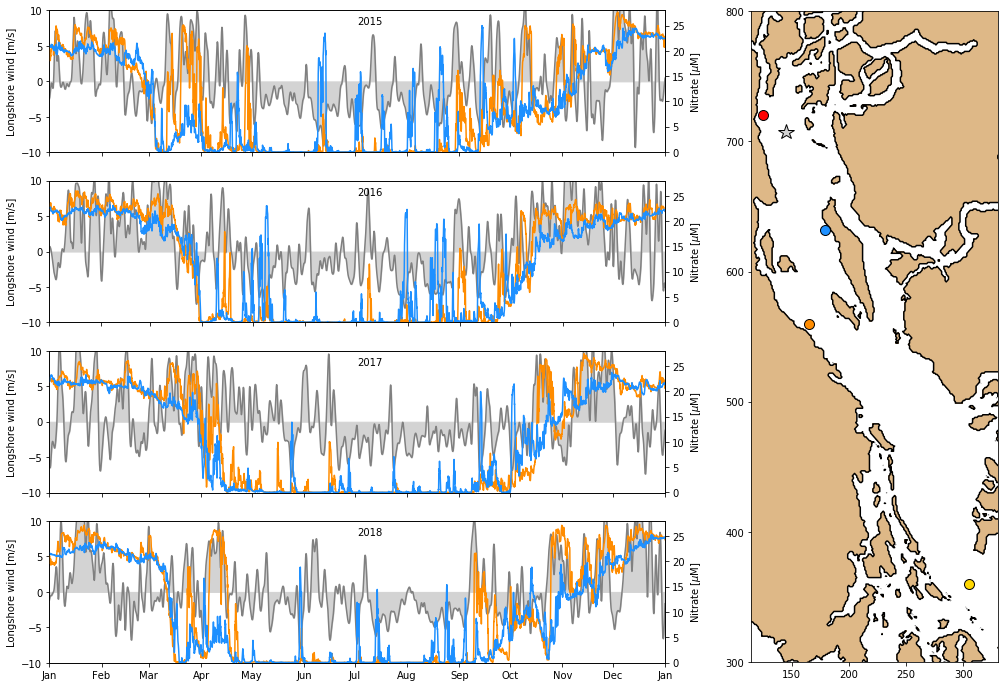

In [15]:
# Plot HRDPS and hindcast timeseries
fig = plt.figure(figsize=(17, 12))
gs = plt.GridSpec(4, 2, width_ratios=(2.5, 1))
axs = [fig.add_subplot(gs[row, 0]) for row in range(4)]
for ax, year in zip(axs, range(2015, 2019)):
    window = [datetime(y, 1, 1) for y in [year, year + 1]]
    ax_right = plot_ts(fig, ax, stations, wind, window)
    ax.text(0.5, 0.9, str(year), transform=ax.transAxes)
    if year < 2018: ax.xaxis.set_ticklabels('')

ax = fig.add_subplot(gs[:, 1])
ax.contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
ax.contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([115, 330])
ax.set_ylim([300, 800])
viz_tools.set_aspect(ax)
for station in stations:
    ax.plot(*station['loc'][::-1], 'o', color=station['c'], markeredgecolor='k', markersize=10)
ax.plot(*places.PLACES['Sentry Shoal']['NEMO grid ji'][::-1], 'k*', markerfacecolor='lightgray', markersize=16)

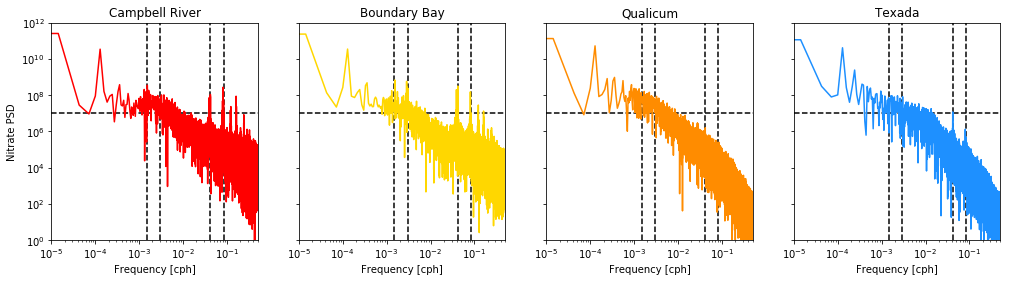

In [22]:
# Plot surface nitrate PSD at coastal stations
xlim, ylim, n = [1e-5, 1/2], [1, 1e12], ptrc.time_counter.size
freq = np.linspace(-1/2, 1/2, n)
peaks = [12, 24, 24*14, 24*28]
fig, axs = plt.subplots(1, 4, figsize=(17, 4))
for ax, station in zip(axs, stations):
    ax.plot(xlim, [1e7, 1e7], 'k--')
    for peak in peaks:
        ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    PSD = abs(fftshift(fft(station['data'])))**2
    ax.plot(freq, PSD, '-', color=station['c'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Frequency [cph]')
    ax.set_title(station['name'])
    if station['name'] == 'Campbell River': ax.set_ylabel('Nitrate PSD')
    else: ax.yaxis.set_ticklabels('')